In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.datasets import fetch_mldata

plt.gray()
%matplotlib inline

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
mnist = fetch_mldata('MNIST original')
x_data = mnist['data'] / 255.0
del mnist

In [3]:
def next_batch(n):
    return x_data[np.random.randint(0, len(x_data), size=n)]

In [100]:
# momentum = 0.9
# def q_net(x, training, reuse=None):
#     h = disc_net(x, training, reuse=reuse)
#     with tf.variable_scope('q_net'): 
#         h = tf.layers.dense(h, 128)
#         h = tf.nn.leaky_relu(h, 0.1)
#         h = tf.layers.batch_normalization(h, training=training, momentum=momentum)
#         q_p = tf.layers.dense(h, 14) # gaussian priors, 10x categorical vars
#     return tf.nn.softmax(q_p[:, :10]), q_p[:, 10:12], tf.nn.softplus(q_p[:, 12:])

# def generator(x, c, training, reuse=None):
#     with tf.variable_scope('generator', reuse=reuse):
#         xc = tf.concat((x, c), axis=1)
#         h = tf.layers.dense(xc, 1024, activation=tf.nn.relu)
#         h = tf.layers.batch_normalization(h, training=training, momentum=momentum)
#         h = tf.layers.dense(h, 7*7*128)
#         h = tf.nn.relu(h)
#         h = tf.reshape(h, (-1, 7, 7, 128))
#         h = tf.layers.batch_normalization(h, training=training, momentum=momentum)
#         h = tf.layers.conv2d_transpose(h, 64, (4,4), strides=(2,2), padding='same')
#         h = tf.nn.relu(h)
#         h = tf.layers.batch_normalization(h, training=training, momentum=momentum)
#         h = tf.layers.conv2d_transpose(h, 1, (4,4), strides=(2,2), padding='same')
#         g_prob = tf.nn.sigmoid(h)
#     return g_prob

# def disc_net(x, training, reuse=None):
#     with tf.variable_scope('base_net', reuse=reuse):
#         h = tf.layers.conv2d(x, 64, (4,4), strides=(2,2))
#         h = tf.nn.leaky_relu(h, 0.1)
#         h = tf.layers.conv2d(h, 128, (4,4), strides=(2,2))
#         h = tf.nn.leaky_relu(h, 0.1)
#         h = tf.layers.batch_normalization(h, training=training, momentum=momentum)
#         h = tf.layers.dense(tf.layers.flatten(h), 1024)
#         h = tf.nn.leaky_relu(h, 0.1)
#         h = tf.layers.batch_normalization(h, training=training, momentum=momentum)
#     return h

# def discriminator(x, training, reuse=None, reuse_n=None):
#     d_h = disc_net(x, training, reuse=reuse_n)
#     with tf.variable_scope('disc', reuse=reuse):
#         g_prob = tf.layers.dense(d_h, 1, activation=tf.nn.sigmoid)
#     return g_prob

# def gauss_logli(x, mu, std):
#     return tf.reduce_sum(-0.5 * np.log(2*np.pi) - tf.log(std + 1e-8) - 0.5 * (x-mu)**2 / std**2, axis=1)

# def log_gauss_other_thing(x):
#     return tf.log(tf.reduce_sum(-0.5*x**2, axis=1))

In [153]:
momentum = 0.9
def q_net(x, training, reuse=None):
    h = disc_net(x, training, reuse=reuse)
    with tf.variable_scope('q_net'): 
        h = tf.layers.dense(h, 64)
        h = tf.nn.leaky_relu(h, 0.1)
        h = tf.layers.batch_normalization(h, training=training, momentum=momentum)
        q_p = tf.layers.dense(h, 14) # gaussian priors, 10x categorical vars
    return tf.nn.softmax(q_p[:, :10]), q_p[:, 10:12], tf.nn.softplus(q_p[:, 12:])

def generator(x, c, training, reuse=None):
    with tf.variable_scope('generator', reuse=reuse):
        xc = tf.concat((x, c), axis=1)
        h = tf.layers.dense(xc, 512, activation=tf.nn.relu)
        h = tf.layers.batch_normalization(h, training=training, momentum=momentum)
        h = tf.layers.dense(h, 7*7*64)
        h = tf.nn.relu(h)
        h = tf.reshape(h, (-1, 7, 7, 64))
        h = tf.layers.batch_normalization(h, training=training, momentum=momentum)
        h = tf.layers.conv2d_transpose(h, 32, (4,4), strides=(2,2), padding='same')
        h = tf.nn.relu(h)
        h = tf.layers.batch_normalization(h, training=training, momentum=momentum)
        h = tf.layers.conv2d_transpose(h, 1, (4,4), strides=(2,2), padding='same')
        g_prob = tf.nn.sigmoid(h)
    return g_prob

def disc_net(x, training, reuse=None):
    with tf.variable_scope('base_net', reuse=reuse):
        h = tf.layers.conv2d(x, 32, (4,4), strides=(2,2))
        h = tf.nn.leaky_relu(h, 0.1)
        h = tf.layers.conv2d(h, 64, (4,4), strides=(2,2))
        h = tf.nn.leaky_relu(h, 0.1)
        h = tf.layers.batch_normalization(h, training=training, momentum=momentum)
        h = tf.layers.dense(tf.layers.flatten(h), 512)
        h = tf.nn.leaky_relu(h, 0.1)
        h = tf.layers.batch_normalization(h, training=training, momentum=momentum)
    return h

def discriminator(x, training, reuse=None, reuse_n=None):
    d_h = disc_net(x, training, reuse=reuse_n)
    with tf.variable_scope('disc', reuse=reuse):
        g_prob = tf.layers.dense(d_h, 1, activation=tf.nn.sigmoid)
    return g_prob

def gauss_logli(x, mu, std):
    return tf.reduce_sum(-0.5 * np.log(2*np.pi) - tf.log(std + 1e-8) - 0.5 * (x-mu)**2 / std**2, axis=1)

def log_gauss_other_thing(x):
    return tf.log(tf.reduce_sum(-0.5*x**2, axis=1))

In [157]:
z_dim = 62

In [163]:
g = tf.Graph()
with g.as_default():
    Z_in = tf.placeholder(tf.float32, (None, z_dim))
    c_in = tf.placeholder(tf.float32, (None, 12))
    X_in = tf.placeholder(tf.float32, (None, 28, 28, 1))
    is_training = tf.placeholder_with_default(False, ())
    
    g_sample = generator(Z_in, c_in, is_training)
    d_fake = discriminator(g_sample, is_training)
    d_real = discriminator(X_in, is_training, True, True)
    qc_x, mus, sds = q_net(g_sample, is_training, True)
    
    d_loss = -tf.reduce_mean(tf.log(d_real + 1e-8) + tf.log(1-d_fake + 1e-8))
    g_loss = -tf.reduce_mean(tf.log(d_fake + 1e-8))
    
    q_ce = -tf.reduce_mean(tf.reduce_sum(tf.log(qc_x+1e-8) * c_in[:, :10], axis=1))
    q_ent = -tf.reduce_mean(tf.reduce_sum(tf.log(c_in[:, :10]+1e-8) * c_in[:, :10], axis=1))

    qgce = -tf.reduce_mean(gauss_logli(c_in[:, 10:], mus, sds))
#     qgp = -tf.reduce_mean(log_gauss_other_thing(c_in))
    
    q_lb = q_ce + q_ent + qgce
    
    
    base_net_vars = g.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'base_net')
    q_vars = g.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') \
        + base_net_vars\
        + g.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'q_net')
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_step = tf.train.AdamOptimizer(2e-4, beta1=0.5).minimize(
            d_loss, var_list=g.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'disc') + base_net_vars)
        g_step = tf.train.AdamOptimizer(1e-3, beta1=0.5).minimize(
            g_loss, var_list=g.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator'))
        q_step = tf.train.AdamOptimizer(2e-4, beta1=0.5).minimize(q_lb, var_list=q_vars)

In [168]:
try:
    while True:
        tf.get_default_session().close()
except: pass
sess = tf.InteractiveSession(graph=g)
sess.run(tf.global_variables_initializer())

In [169]:
bs = 32

In [170]:
def sample_z(*shape):
    return np.random.uniform(-1, 1.0, shape)
def sample_c(n):
    return np.append(np.random.multinomial(1, [0.1]*10, size=n), sample_z(n, 2), axis=1)

In [171]:
dls = []
gls = []
save_every=200
N1 = 4
np.random.seed(10918283)
ref_c = sample_c(N1**2)
ref_z = sample_z(N1**2, z_dim)
for iteration in range(len(dls), 100000):
    if iteration % save_every == 0:
        ims = sess.run(g_sample, feed_dict={Z_in: ref_z, c_in: ref_c}).reshape(-1, 28, 28)
        fig = plt.figure(figsize=(16, 16))
        for i in range(N1*N1):
            ax = fig.add_subplot(N1, N1, i+1)
            ax.imshow(ims[i])
            ax.axis('off')
        fig.savefig('/Users/nikil/Downloads/out/%d.png'%(iteration//save_every))
        plt.close()
    xb = next_batch(bs).reshape(-1, 28, 28, 1)
    z_ = sample_z(bs, z_dim)
    c_ = sample_c(bs)
    _, dl = sess.run([d_step, d_loss], feed_dict={X_in: xb, Z_in: z_, c_in: c_, is_training:True})
    
#     z_ = sample_z(bs, z_dim)
#     c_ = sample_c(bs)
    _, gl = sess.run([g_step, g_loss], feed_dict={X_in: xb, Z_in: z_, c_in: c_, is_training:True})
    
    sess.run([q_step], feed_dict={X_in: xb, Z_in: z_, c_in: c_, is_training:True})
    dls.append(dl)
    gls.append(gl)
    if iteration % 100 == 0:
        print(f'Iter {iteration}, Discriminator loss: {dl:.5f}, Generator loss: {gl:.5f}')

Iter 0, Discriminator loss: 1.83384, Generator loss: 0.73969
Iter 100, Discriminator loss: 1.48812, Generator loss: 0.70835
Iter 200, Discriminator loss: 1.45864, Generator loss: 0.69970
Iter 300, Discriminator loss: 1.43683, Generator loss: 0.70422
Iter 400, Discriminator loss: 1.42155, Generator loss: 0.70122
Iter 500, Discriminator loss: 1.40739, Generator loss: 0.69903
Iter 600, Discriminator loss: 1.41025, Generator loss: 0.69996
Iter 700, Discriminator loss: 1.41257, Generator loss: 0.69916
Iter 800, Discriminator loss: 1.40325, Generator loss: 0.69710
Iter 900, Discriminator loss: 1.40389, Generator loss: 0.69773
Iter 1000, Discriminator loss: 1.39469, Generator loss: 0.69594
Iter 1100, Discriminator loss: 1.39985, Generator loss: 0.69591
Iter 1200, Discriminator loss: 1.39496, Generator loss: 0.69561
Iter 1300, Discriminator loss: 1.39550, Generator loss: 0.69500
Iter 1400, Discriminator loss: 1.39165, Generator loss: 0.69530
Iter 1500, Discriminator loss: 1.39111, Generator lo

KeyboardInterrupt: 

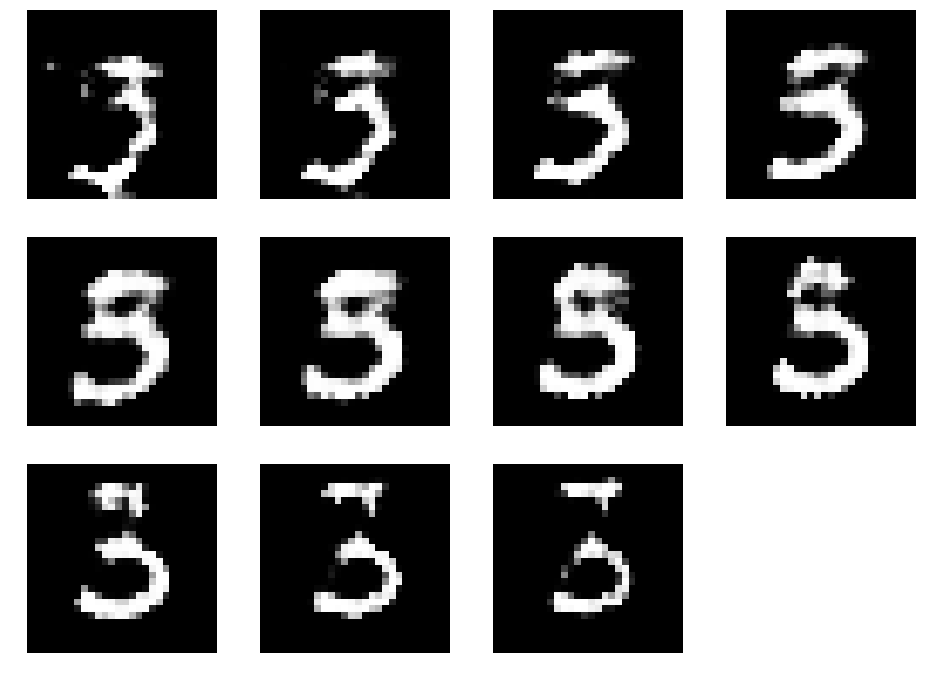

In [69]:
zs = sample_z(11, z_dim)
zs = np.zeros((11, z_dim))
cs = np.zeros((11, 12))
cs[:, 0] = 1
cs[:, -1] = np.linspace(-2, 2, 11)
fig = plt.figure(figsize=(16, 16))
ims = sess.run(g_sample, feed_dict={Z_in: zs, c_in: cs}).reshape(-1, 28, 28)
for i in range(11):
    ax = plt.subplot(4, 4, i+1)
    ax.imshow(ims[i])
    ax.axis('off')

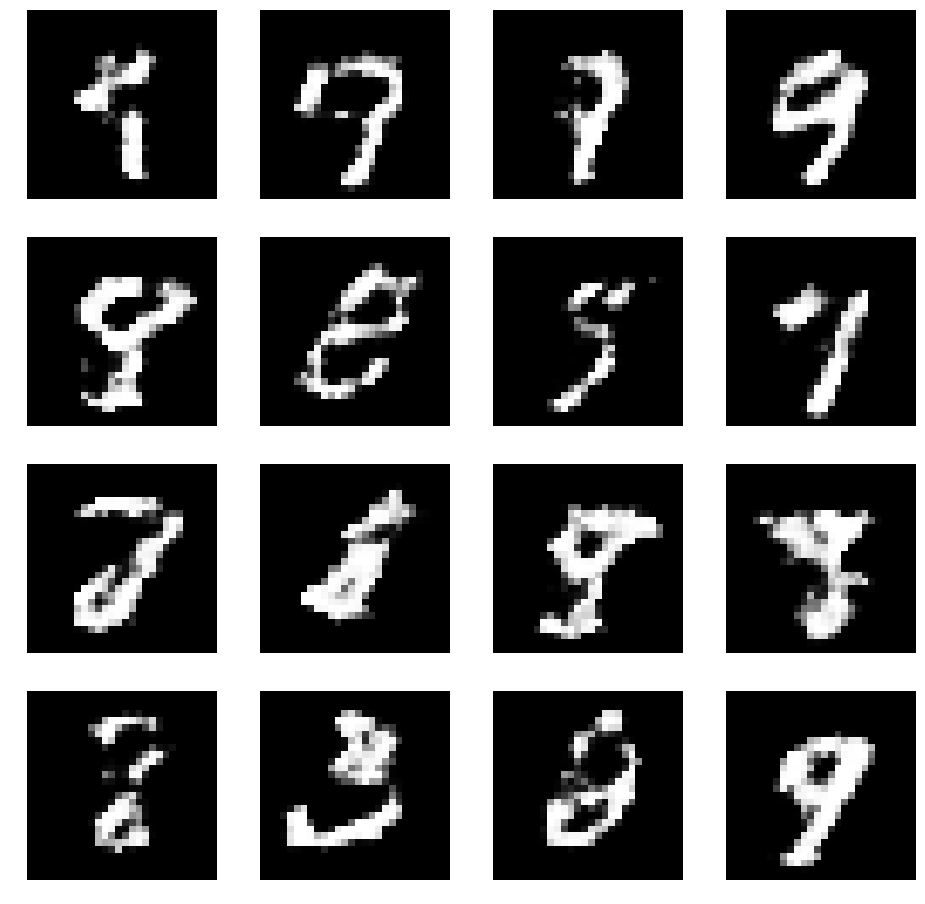

In [67]:
N1 = 4
fig = plt.figure(figsize=(16, 16))
z_ = sample_z(N1**2, z_dim)
c_ = sample_c(N1**2)
ims = sess.run(g_sample, feed_dict={Z_in: z_, c_in: c_}).reshape(-1, 28, 28)
for i in range(N1*N1):
    ax = fig.add_subplot(N1, N1, i+1)
    ax.imshow(ims[i])
    ax.axis('off')